In [34]:
import osmnx as ox
import pandas as pd

import numpy as np
import matplotlib.pyplot as pl

import networkx as nx

import os

import geopy

import sys



In [35]:
#sys.path.append("/home/charles/Projects/Plaques/Python/OsmnxStreets")
sys.path.append("/home/charles/Projects/Plaques/Python")  #this is the important line!!!

In [36]:
os.getcwd()

'/home/charles/Projects/Plaques/Python/OsmnxStreets'

In [37]:
os.chdir( "/home/charles/Projects/Plaques/Python/OsmnxStreets") 

In [38]:
import OsmnxStreets

In [39]:
ox.config(log_file=True, log_console=True, use_cache=True)

In [40]:
#Just qc graph
place=['Québec city, canada']


graphQc = ox.graph_from_place(place, 
                       simplify=False,
                       retain_all=True)

In [41]:
#geopandas ie sf like
qcCity = ox.gdf_from_place(place[0])
qcCity.head()

bbox_east  bbox_north  bbox_south  bbox_west  \
0 -71.133661    46.98068    46.72771 -71.549217   

                                            geometry  \
0  POLYGON ((-71.5492175 46.8511815, -71.5313905 ...   

                                          place_name  
0  Quebec City, Québec (Agglomération), Capitale-...

In [42]:
print( type(graphQc) )
print( type(qcCity))

<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'geopandas.geodataframe.GeoDataFrame'>


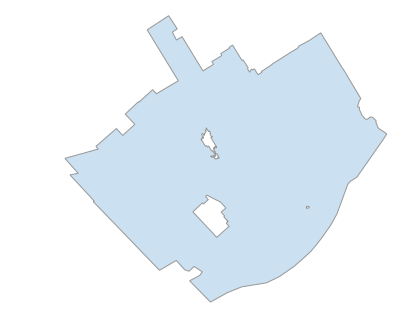

In [42]:
city = ox.project_gdf(qcCity)
fig, ax = ox.plot_shape(city)

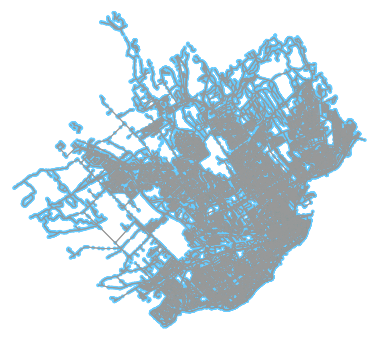

In [43]:
#this is f**long nx.draw(graphQc)
fig, ax = ox.plot_graph(graphQc)

In [43]:
dictBbox={"xmin": -71.24047, 
        "ymin" :  46.79089,
        "xmax" : -71.19298,
        "ymax" : 46.83216 }
matBbox=np.array([v for k, v in dictBbox.items() ]).reshape(2,2).transpose()
dict2={}
dict2["key"] = ["min","max"]
dict2["lng"] = matBbox[0,:]
dict2["lat"] = matBbox[1,:]
dfBbox=pd.DataFrame.from_dict(dict2)
dfBbox

key       lng       lat
0  min -71.24047  46.79089
1  max -71.19298  46.83216

In [44]:

dfBbox["dummy"] = np.ones(dfBbox.shape[0])

dfMerged=pd.merge(dfBbox,dfBbox,
        on="dummy")

dfMerged.drop(columns={"dummy"},inplace=True)

dfMerged

key_x     lng_x     lat_x key_y     lng_y     lat_y
0   min -71.24047  46.79089   min -71.24047  46.79089
1   min -71.24047  46.79089   max -71.19298  46.83216
2   max -71.19298  46.83216   min -71.24047  46.79089
3   max -71.19298  46.83216   max -71.19298  46.83216

In [45]:
dfExtremePoints=dfMerged.loc[:, ["lat_y","lng_x"]]  #permute lat lng for omsnx
dfExtremePoints

lat_y     lng_x
0  46.79089 -71.24047
1  46.83216 -71.24047
2  46.79089 -71.19298
3  46.83216 -71.19298

In [46]:
centroid=dfExtremePoints.apply( lambda x: np.mean(x))
print(type(centroid))
centroid.values

<class 'pandas.core.series.Series'>


array([ 46.811525, -71.216725])

In [47]:
bufferMeters=1*10**3
graphQcReduced = ox.graph_from_point(centroid.values,distance=bufferMeters) #use a buffer of 10 km around the centroid of the bounding box

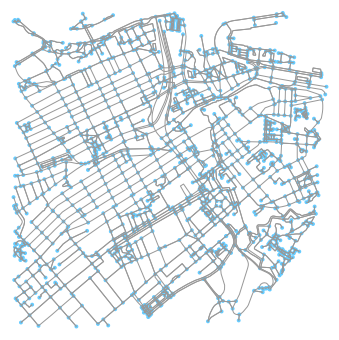

In [48]:
fig, ax= ox.plot_graph(graphQcReduced)

In [49]:
 dfMerged

key_x     lng_x     lat_x key_y     lng_y     lat_y
0   min -71.24047  46.79089   min -71.24047  46.79089
1   min -71.24047  46.79089   max -71.19298  46.83216
2   max -71.19298  46.83216   min -71.24047  46.79089
3   max -71.19298  46.83216   max -71.19298  46.83216

In [50]:
ROOT_DIR = "/home/charles/Projects/Plaques"
#"/home/dhw3172/projects/Plaques" 

In [51]:
dfStreets=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","Streets", "uniqueStreetsWithLngLat.csv"),delimiter=",")

In [52]:
dfStreets=dfStreets.loc[ ~dfStreets.isna().any(axis=1),  ]
dfStreets.reset_index(inplace=True) #reset the index
dfStreets.head(2)

index               Street   lngStart   latStart     lngEnd     latEnd
0      0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753
1      1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131

In [53]:
def checkWithinInterval(x, xmin, xmax):
    return( (x <= xmax) & (x >= xmin))

In [54]:
#Make sure within the bouding box
def checkBoxRow(i, dfStreets, dfBox):
    return( 
        checkWithinInterval( dfStreets.loc[i, "lngStart"] , dfBox.loc [0, "lng_x"] , dfBox.loc [3, "lng_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "lngEnd"]   , dfBox.loc [0,"lng_x"] ,  dfBox.loc [3,"lng_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "latStart"] , dfBox.loc [0,"lat_x"] ,  dfBox.loc [3,"lat_y"] ) &
        checkWithinInterval( dfStreets.loc[i, "latEnd"]   , dfBox.loc [0,"lat_x"] ,  dfBox.loc [3,"lat_y"] )
  )


In [55]:
checkBoxRow( 0, dfStreets, dfMerged )
dfMerged.loc [3,"lng_y"] <= dfStreets.loc [3,"lngStart"]
dfStreets.loc [0,"lngStart"]
(dfStreets.loc[0, "lngStart"] >= dfMerged.loc [0, "lng_x"]) & (dfStreets.loc[0, "lngStart"] <= dfMerged.loc [3, "lng_y"] ) 

idxInBbox=[ checkBoxRow( k, dfStreets, dfMerged ) for k in range(dfStreets.shape[0]) ]
print("Watch out! some of the endpoints of the following streets fall outside the bounding box: ", dfStreets.loc[ np.isin(idxInBbox,False), "Street"])



Watch out! some of the endpoints of the following streets fall outside the bounding box:  11                  rue Burton
12              côte d’Abraham
13         rue Philippe-Dorval
37    rue Monseigneur-De-Laval
39             rue des Grisons
Name: Street, dtype: object


In [56]:
checkBoxAll(dfStreets,dfMerged )

NameError: name 'checkBoxAll' is not defined

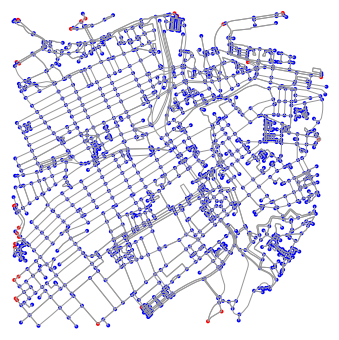

(<Figure size 630.034x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f24d0e05630>)

In [21]:
colorMapNodes = ["b" if ox.is_endpoint(G=graphQcReduced,node=n) else "r" for n in graphQcReduced.nodes()]
ox.plot_graph(graphQcReduced,node_color=colorMapNodes )

In [57]:
dfConcat=pd.concat( [dfStreets.loc[: ,["lngStart", "latStart"]].rename(columns={"lngStart":"lng", "latStart": "lat"})  ,
            dfStreets.loc[: ,["lngEnd", "latEnd"]].rename(columns={"lngEnd":"lng", "latEnd": "lat"}) ] ,
            ignore_index=True)
dfConcat.tail()

lng        lat
85 -71.210863  46.813189
86 -71.208329  46.809760
87 -71.205474  46.812345
88 -71.204809  46.810766
89 -71.208106  46.814731

In [58]:
lngLatDup=dfConcat.loc[ dfConcat.duplicated(), ["lng","lat"] ].values

In [59]:
idxDup=[np.all(np.isin([True,True],k)) for k in np.isin(  dfStreets[["lngStart", "latStart"]], lngLatDup )  ]

In [60]:
dfConcatNew=dfConcat.drop_duplicates(keep="first")
print("removed", dfConcat.shape[0]-dfConcatNew.shape[0], "duplicate rows")
print(dfStreets.loc[ idxDup , :] )

removed 1 duplicate rows
   index                  Street   lngStart   latStart     lngEnd    latEnd
9     10  rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147  46.81464


In [61]:
#Watch out with the index!
dfConcat = dfConcatNew.copy()
dfConcat.reset_index(inplace=True)
dfConcat.head()
#[ str(dfConcat.loc[i,"lng"]) + "_" + str(dfConcat.loc[i,"lat"]) for i in range(dfConcat.shape[0])]

index        lng        lat
0      0 -71.211626  46.808025
1      1 -71.228938  46.807552
2      2 -71.218576  46.810208
3      3 -71.228321  46.801381
4      4 -71.228021  46.806901

In [62]:
numNodes=len(graphQcReduced.nodes())
listIndices=[k[0] for k in graphQcReduced.nodes.items()]

In [63]:
dummyStart=max(listIndices)+1
for i in range(dfConcat.shape[0]): 
     graphQcReduced.add_node(dummyStart+i , 
                             x=dfConcat.loc[i,"lng"] , 
                             y=dfConcat.loc[i,"lat"])
dfConcat["index"] = [dummyStart+i for i in range(dfConcat.shape[0])]
print(dfConcat.shape)
dfConcat


(89, 3)


index        lng        lat
0   6336677178 -71.211626  46.808025
1   6336677179 -71.228938  46.807552
2   6336677180 -71.218576  46.810208
3   6336677181 -71.228321  46.801381
4   6336677182 -71.228021  46.806901
5   6336677183 -71.226094  46.808916
6   6336677184 -71.221944  46.801154
7   6336677185 -71.214731  46.812947
8   6336677186 -71.227488  46.806574
9   6336677187 -71.215778  46.812134
10  6336677188 -71.227089  46.806199
11  6336677189 -71.221684  46.807976
12  6336677190 -71.222952  46.812147
13  6336677191 -71.225183  46.808343
14  6336677192 -71.221426  46.809437
15  6336677193 -71.222752  46.802777
16  6336677194 -71.220741  46.803981
17  6336677195 -71.231359  46.812907
18  6336677196 -71.224163  46.817169
19  6336677197 -71.224910  46.814540
20  6336677198 -71.223101  46.812264
21  6336677199 -71.231054  46.818843
22  6336677200 -71.231147  46.812719
23  6336677201 -71.222104  46.812602
24  6336677202 -71.230792  46.811875
25  6336677203 -71.206322  46.814673
26  6336677204 -71.209135  46.814698
27  6336677205 -71.212467  46.815730
28  6336677206 -71.208192  46.811824
29  6336677207 -71.206378  46.811075
..         ...        ...        ...
59  6336677237 -71.212004  46.808976
60  6336677238 -71.225341  46.808086
61  6336677239 -71.217596  46.817295
62  6336677240 -71.223552  46.816354
63  6336677241 -71.218417  46.816637
64  6336677242 -71.213256  46.815700
65  6336677243 -71.224477  46.811912
66  6336677244 -71.217529  46.816992
67  6336677245 -71.225149  46.816927
68  6336677246 -71.224569  46.813931
69  6336677247 -71.207158  46.816178
70  6336677248 -71.208100  46.815313
71  6336677249 -71.210161  46.814276
72  6336677250 -71.207848  46.811523
73  6336677251 -71.205617  46.809896
74  6336677252 -71.209401  46.809525
75  6336677253 -71.209089  46.817433
76  6336677254 -71.204298  46.815730
77  6336677255 -71.205193  46.811501
78  6336677256 -71.205419  46.813013
79  6336677257 -71.208315  46.809705
80  6336677258 -71.204316  46.815818
81  6336677259 -71.205107  46.815649
82  6336677260 -71.206772  46.814107
83  6336677261 -71.206116 -71.206850
84  6336677262 -71.210863  46.813189
85  6336677263 -71.208329  46.809760
86  6336677264 -71.205474  46.812345
87  6336677265 -71.204809  46.810766
88  6336677266 -71.208106  46.814731

[89 rows x 3 columns]

In [64]:
dfStreets.head(3)
print(dfStreets.shape)

(45, 6)


In [65]:
dfStreetsMergedStart=pd.merge( dfStreets, dfConcat, 
         how="left",
         left_on=["lngStart","latStart"],
         right_on =["lng","lat"])
dfStreetsMergedStart.rename(columns={"index_y":"idxStart"} ,inplace=True)

In [66]:
dfStreetsMergedStartEnd=pd.merge( dfStreetsMergedStart, dfConcat, 
         how="left",
         left_on=["lngEnd","latEnd"],
         right_on =["lng","lat"])
dfStreetsMergedStartEnd
dfStreetsMergedStartEnd.rename(columns={"index":"idxEnd"} ,inplace=True)

In [67]:
dfStreetsMergedStartEnd.head(3)
print(dfStreetsMergedStartEnd.shape)

(45, 12)


In [68]:

newColMap = [  "r" for k in range(len(listIndices)) ] + ["b" for k in range(dfConcat.shape[0])]

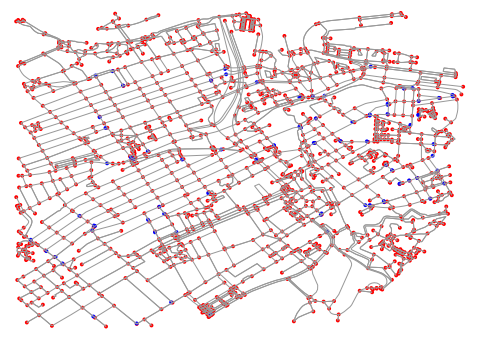

(<Figure size 630.034x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f484b87b898>)

In [69]:
ox.plot_graph(graphQcReduced,node_color=newColMap )

In [70]:
type(graphQcReduced)

networkx.classes.multidigraph.MultiDiGraph

In [71]:
dfStreetsMergedStartEnd.head()

index_x               Street   lngStart   latStart     lngEnd     latEnd  \
0        0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753   
1        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
2        3    rue Saint-Gabriel -71.218576  46.810208 -71.222092  46.808695   
3        4         rue Aberdeen -71.228321  46.801381 -71.225280  46.803173   
4        5        rue Richelieu -71.228021  46.806901 -71.213253  46.813998   

     idxStart      lng_x      lat_x      idxEnd      lng_y      lat_y  
0  6336677178 -71.211626  46.808025  6336677223 -71.222580  46.801753  
1  6336677179 -71.228938  46.807552  6336677224 -71.220098  46.812131  
2  6336677180 -71.218576  46.810208  6336677225 -71.222092  46.808695  
3  6336677181 -71.228321  46.801381  6336677226 -71.225280  46.803173  
4  6336677182 -71.228021  46.806901  6336677227 -71.213253  46.813998

In [72]:
import geopy.distance


dfStreetsMergedStartEnd.loc[0,["lngStart","latStart"]].tolist()
geopy.distance.distance(dfStreetsMergedStartEnd.loc[0,["lngStart","latStart"]].tolist() ,
                        dfStreetsMergedStartEnd.loc[0,["lngEnd", "latEnd"] ].tolist())


Distance(1.2428403351964936)

In [73]:
 

def computeDistanceRow(dfStreetsMergedStartEnd, k):
    return( 
        geopy.distance.distance(dfStreetsMergedStartEnd.loc[k,["lngStart","latStart"]].tolist() , 
                            dfStreetsMergedStartEnd.loc[k,["lngEnd", "latEnd"] ].tolist() )
          ).m

    
dfStreetsMergedStartEnd["distance"] = [computeDistanceRow(dfStreetsMergedStartEnd,i) for i in range(dfStreetsMergedStartEnd.shape[0])]
print(dfStreetsMergedStartEnd.shape)
dfStreetsMergedStartEnd


(45, 13)


index_x                    Street   lngStart   latStart     lngEnd  \
0         0       rue Wilfrid-Laurier -71.211626  46.808025 -71.222580   
1         1        rue de la Tourelle -71.228938  46.807552 -71.220098   
2         3         rue Saint-Gabriel -71.218576  46.810208 -71.222092   
3         4              rue Aberdeen -71.228321  46.801381 -71.225280   
4         5             rue Richelieu -71.228021  46.806901 -71.213253   
5         6         rue Saint-Olivier -71.226094  46.808916 -71.217819   
6         7          rue De Bernières -71.221944  46.801154 -71.218423   
7         8           rue D’Aiguillon -71.214731  46.812947 -71.225250   
8         9        rue Saint-Jean sjb -71.227488  46.806574 -71.215778   
9        10    rue Saint-Jean vieuxqc -71.215778  46.812134 -71.209147   
10       11              rue Lockwell -71.227089  46.806199 -71.221150   
11       12                rue Burton -71.221684  46.807976  46.808446   
12       13            côte d’Abraham -71.222952  46.812147  46.812998   
13       15       rue Philippe-Dorval -71.225183  46.808343  46.809525   
14       16                 rue Scott -71.221426  46.809437 -71.220429   
15       17          Grande-Allée Est -71.222752  46.802777 -71.212004   
16       18              rue Turnbull -71.220741  46.803981 -71.225341   
17       20                rue du Roi -71.231359  46.812907 -71.217596   
18       21             avenue Daulac -71.224163  46.817169 -71.223552   
19       22    rue Saint-François Est -71.224910  46.814540 -71.218417   
20       23  rue De Saint-Vallier Est -71.223101  46.812264 -71.213256   
21       24            rue Dorchester -71.231054  46.818843 -71.224477   
22       25      rue Saint-Joseph Est -71.231147  46.812719 -71.217529   
23       26             rue du Parvis -71.222104  46.812602 -71.225149   
24       27  rue Notre-Dame-des-Anges -71.230792  46.811875 -71.224569   
25       28               rue Ferland -71.206322  46.814673 -71.207158   
26       29             rue Couillard -71.209135  46.814698 -71.208100   
27       30            côte du Palais -71.212467  46.815730 -71.210161   
28       31            rue du Parloir -71.208192  46.811824 -71.207848   
29       32           rue de la Porte -71.206378  46.811075 -71.205617   
30       33             rue D’Auteuil -71.213164  46.813946 -71.209401   
31       34            rue Saint-Paul -71.215740  46.816545 -71.209089   
32       35                rue Hébert -71.206288  46.815469 -71.204298   
33       36           rue Mont-Carmel -71.207408  46.810748 -71.205193   
34       37           rue Sainte-Anne -71.209313  46.813167 -71.205419   
35       38          rue Saint-Ursule -71.212354  46.813079 -71.208315   
36       39          rue des Remparts -71.211780  46.815774 -71.204316   
37       40  rue Monseigneur-De-Laval  46.815814  46.815814 -71.205107   
38       41        rue Sainte-Famille -71.206653  46.816214 -71.206772   
39       42           rue des Grisons -71.206850  46.810935 -71.206116   
40       43       rue Saint-Stanislas -71.212295  46.814474 -71.210863   
41       44         rue Sainte-Ursule -71.212413  46.813079 -71.208329   
42       46           rue Saint-Louis -71.211960  46.809055 -71.205474   
43       47   avenue Sainte-Geneviève -71.209141  46.809533 -71.204809   
44       48              rue Christie -71.208095  46.815249 -71.208106   

       latEnd    idxStart      lng_x      lat_x      idxEnd      lng_y  \
0   46.801753  6336677178 -71.211626  46.808025  6336677223 -71.222580   
1   46.812131  6336677179 -71.228938  46.807552  6336677224 -71.220098   
2   46.808695  6336677180 -71.218576  46.810208  6336677225 -71.222092   
3   46.803173  6336677181 -71.228321  46.801381  6336677226 -71.225280   
4   46.813998  6336677182 -71.228021  46.806901  6336677227 -71.213253   
5   46.812698  6336677183 -71.226094  46.808916  6336677228 -71.217819   
6   46.803313  6336677184 -71.221944  46.801154  6336677229 -71.218423   
7   46.

In [74]:
for k in range(dfStreetsMergedStartEnd.shape[0]):
    graphQcReduced.add_edge(u_for_edge=dfStreetsMergedStartEnd.loc[k,"idxStart"],
                            v_for_edge=dfStreetsMergedStartEnd.loc[k,"idxEnd"],
                           color="b")
    

In [75]:
#[ e for e in graphQcReduced.edges()]
listEdgesNew=[k[:2] for k,v in nx.get_edge_attributes(graphQcReduced,"color").items() ]

In [76]:
edgeColors=[ "b" if e in listEdgesNew else "gray" for e in graphQcReduced.edges()]

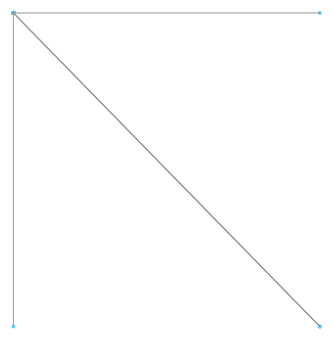

(<Figure size 431.999x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f484bb5f400>)

In [78]:
type(graphQcReduced)
ox.plot_graph(graphQcReduced) #, edge_color=edgeColors)

In [114]:
dfStreetsMergedStartEnd.head()
print(dfStreetsMergedStartEnd.shape)
dfStreetsMergedStartEnd.columns
#dfStreetsMergedStartEnd["distance"]

(33, 13)


Index(['index_x', 'Street', 'lngStart', 'latStart', 'lngEnd', 'latEnd',
       'idxStart', 'lng_x', 'lat_x', 'idxEnd', 'lng_y', 'lat_y', 'distance'],
      dtype='object')

In [117]:
dfPlaquesWithAdress=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","NoLngLat", "AllNeighbourhoods", "plaquesTidy.csv"))

In [120]:
dfStreetsMergedStartEnd=pd.merge(dfStreetsMergedStartEnd, dfPlaquesWithAdress,
         how="left",
         on="Street")
dfStreetsMergedStartEnd.head()

index_x               Street   lngStart   latStart     lngEnd     latEnd  \
0        0  rue Wilfrid-Laurier -71.211626  46.808025 -71.222580  46.801753   
1        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
2        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
3        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   
4        1   rue de la Tourelle -71.228938  46.807552 -71.220098  46.812131   

     idxStart      lng_x      lat_x      idxEnd        ...             lat_y  \
0  6336677178 -71.211626  46.808025  6336677211        ...         46.801753   
1  6336677179 -71.228938  46.807552  6336677212        ...         46.812131   
2  6336677179 -71.228938  46.807552  6336677212        ...         46.812131   
3  6336677179 -71.228938  46.807552  6336677212        ...         46.812131   
4  6336677179 -71.228938  46.807552  6336677212        ...         46.812131   

      distance              Name_x                Address_x  \
0  1242.840335      Alleyn, Edmund  85, rue Wilfrid-Laurier   
1   999.974435       Angers, Henri  166, rue de la Tourelle   
2   999.974435       Angers, Henri  166, rue de la Tourelle   
3   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   
4   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   

     Neighbourhood_x         Borough_x              Name_y  \
0  SaintJeanBaptiste  La Cité-Limoilou      Alleyn, Edmund   
1  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
2  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   
3  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
4  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   

                 Address_y    Neighbourhood_y         Borough_y  
0  85, rue Wilfrid-Laurier  SaintJeanBaptiste  La Cité-Limoilou  
1  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
2  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
3  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
4  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  

[5 rows x 21 columns]

In [88]:
import seaborn as sns

/home/charles/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


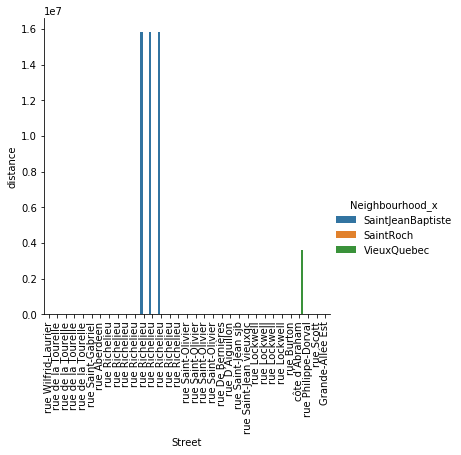

In [132]:
g=sns.catplot(x="Street",
              y="distance",
              hue="Neighbourhood_x",
              data=dfStreetsMergedStartEnd,
              kind="bar")
g.set_xticklabels(labels=dfStreetsMergedStartEnd["Street"], rotation=90)

In [133]:
dfPlaques=pd.read_csv(os.path.join(ROOT_DIR,"Data","Csv","WithLngLat", "AllNeighbourhoods", "plaquesTidyManTweak.csv"))
dfPlaques.head()

Unnamed: 0            accuracy  \
0           0  RANGE_INTERPOLATED   
1           1             ROOFTOP   
2           2             ROOFTOP   
3           3  RANGE_INTERPOLATED   
4           4             ROOFTOP   

                                   formatted_address  \
0  85 Rue Wilfrid-Laurier, Sherbrooke, QC J1C 0P3...   
1  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
2  16 Avenue Wilfrid-Laurier, Québec, QC G1R 2K7,...   
3    559 Rue Saint Gabriel, Montréal, QC H2Y, Canada   
4        49 Rue Aberdeen, Québec, QC G1R 2C6, Canada   

                                     google_place_id  \
0  EjY4NSBSdWUgV2lsZnJpZC1MYXVyaWVyLCBTaGVyYnJvb2...   
1                        ChIJQxgec3qWuEwR0egFgivENsI   
2                        ChIJV2IOYn-WuEwRYYlFg0cqNU8   
3  Eiw1NTkgUnVlIFNhaW50IEdhYnJpZWwsIE1vbnRyw6lhbC...   
4                        ChIJg3-hL3-WuEwR6MZoNRYzDGA   

                               input_string   latitude  longitude  \
0     85, rue Wilfrid-Laurier,Quebec,Canada  46.802202 -71.221648   
1     166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
2  16, avenue Wilfrid-Laurier,Quebec,Canada  46.801998 -71.222519   
3      559, rue Saint-Gabriel,Quebec,Canada  46.809447 -71.220046   
4            49, rue Aberdeen,Quebec,Canada  46.803411 -71.224442   

   number_of_results postcode status            type               Name  \
0                  3  G1R 2K6     OK  street_address     Alleyn, Edmund   
1                  1  G1R 1C4     OK  street_address      Angers, Henri   
2                  1  G1R 2K7     OK         premise       Beetz, Johan   
3                  1  G1R 1W3     OK  street_address  Belley, Henriette   
4                  1  G1R 2C6     OK  street_address    Blatter, Robert   

                      Address      Neighbourhood                  Street  \
0     85, rue Wilfrid-Laurier  SaintJeanBaptiste     rue Wilfrid-Laurier   
1     166, rue de la Tourelle  SaintJeanBaptiste      rue de la Tourelle   
2  16, avenue Wilfrid-Laurier  SaintJeanBaptiste  avenue Wilfrid-Laurier   
3      559, rue Saint-Gabriel  SaintJeanBaptiste       rue Saint-Gabriel   
4            49, rue Aberdeen  SaintJeanBaptiste            rue Aberdeen   

            Borough  
0  La Cité-Limoilou  
1  La Cité-Limoilou  
2  La Cité-Limoilou  
3  La Cité-Limoilou  
4  La Cité-Limoilou

In [134]:
dfPlaquesWithStreetDist=pd.merge(dfPlaques, dfStreetsMergedStartEnd,
         how="left",
         on="Street")

In [135]:
dfPlaquesWithStreetDist.head()

Unnamed: 0            accuracy  \
0           0  RANGE_INTERPOLATED   
1           1             ROOFTOP   
2           1             ROOFTOP   
3           1             ROOFTOP   
4           1             ROOFTOP   

                                   formatted_address  \
0  85 Rue Wilfrid-Laurier, Sherbrooke, QC J1C 0P3...   
1  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
2  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
3  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
4  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   

                                     google_place_id  \
0  EjY4NSBSdWUgV2lsZnJpZC1MYXVyaWVyLCBTaGVyYnJvb2...   
1                        ChIJQxgec3qWuEwR0egFgivENsI   
2                        ChIJQxgec3qWuEwR0egFgivENsI   
3                        ChIJQxgec3qWuEwR0egFgivENsI   
4                        ChIJQxgec3qWuEwR0egFgivENsI   

                            input_string   latitude  longitude  \
0  85, rue Wilfrid-Laurier,Quebec,Canada  46.802202 -71.221648   
1  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
2  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
3  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
4  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   

   number_of_results postcode status        ...             lat_y  \
0                  3  G1R 2K6     OK        ...         46.801753   
1                  1  G1R 1C4     OK        ...         46.812131   
2                  1  G1R 1C4     OK        ...         46.812131   
3                  1  G1R 1C4     OK        ...         46.812131   
4                  1  G1R 1C4     OK        ...         46.812131   

      distance              Name_x                Address_x  \
0  1242.840335      Alleyn, Edmund  85, rue Wilfrid-Laurier   
1   999.974435       Angers, Henri  166, rue de la Tourelle   
2   999.974435       Angers, Henri  166, rue de la Tourelle   
3   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   
4   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   

     Neighbourhood_x         Borough_x              Name_y  \
0  SaintJeanBaptiste  La Cité-Limoilou      Alleyn, Edmund   
1  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
2  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   
3  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
4  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   

                 Address_y    Neighbourhood_y         Borough_y  
0  85, rue Wilfrid-Laurier  SaintJeanBaptiste  La Cité-Limoilou  
1  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
2  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
3  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
4  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  

[5 rows x 36 columns]

In [136]:
dfPlaquesWithStreetDistNoNas = dfPlaquesWithStreetDist.dropna()
dfPlaquesWithStreetDistNoNas.head()

Unnamed: 0            accuracy  \
0           0  RANGE_INTERPOLATED   
1           1             ROOFTOP   
2           1             ROOFTOP   
3           1             ROOFTOP   
4           1             ROOFTOP   

                                   formatted_address  \
0  85 Rue Wilfrid-Laurier, Sherbrooke, QC J1C 0P3...   
1  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
2  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
3  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   
4  166 Rue de la Tourelle, Québec, QC G1R 1C4, Ca...   

                                     google_place_id  \
0  EjY4NSBSdWUgV2lsZnJpZC1MYXVyaWVyLCBTaGVyYnJvb2...   
1                        ChIJQxgec3qWuEwR0egFgivENsI   
2                        ChIJQxgec3qWuEwR0egFgivENsI   
3                        ChIJQxgec3qWuEwR0egFgivENsI   
4                        ChIJQxgec3qWuEwR0egFgivENsI   

                            input_string   latitude  longitude  \
0  85, rue Wilfrid-Laurier,Quebec,Canada  46.802202 -71.221648   
1  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
2  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
3  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   
4  166, rue de la Tourelle,Quebec,Canada  46.808922 -71.226962   

   number_of_results postcode status        ...             lat_y  \
0                  3  G1R 2K6     OK        ...         46.801753   
1                  1  G1R 1C4     OK        ...         46.812131   
2                  1  G1R 1C4     OK        ...         46.812131   
3                  1  G1R 1C4     OK        ...         46.812131   
4                  1  G1R 1C4     OK        ...         46.812131   

      distance              Name_x                Address_x  \
0  1242.840335      Alleyn, Edmund  85, rue Wilfrid-Laurier   
1   999.974435       Angers, Henri  166, rue de la Tourelle   
2   999.974435       Angers, Henri  166, rue de la Tourelle   
3   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   
4   999.974435  Sauvageau, Wilfrid  534, rue de la Tourelle   

     Neighbourhood_x         Borough_x              Name_y  \
0  SaintJeanBaptiste  La Cité-Limoilou      Alleyn, Edmund   
1  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
2  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   
3  SaintJeanBaptiste  La Cité-Limoilou       Angers, Henri   
4  SaintJeanBaptiste  La Cité-Limoilou  Sauvageau, Wilfrid   

                 Address_y    Neighbourhood_y         Borough_y  
0  85, rue Wilfrid-Laurier  SaintJeanBaptiste  La Cité-Limoilou  
1  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
2  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
3  166, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  
4  534, rue de la Tourelle  SaintJeanBaptiste  La Cité-Limoilou  

[5 rows x 36 columns]

In [140]:
dfByStreet=dfPlaquesWithStreetDistNoNas.groupby("Street").sum().reset_index()
dfByStreet.loc[: , ["Street","number_of_results","distance","Neighbourhood_y"]]


/home/charles/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Street  number_of_results      distance  Neighbourhood_y
0           Grande-Allée Est                  1  1.219761e+03              NaN
1              avenue Daulac                  1  7.419933e+01              NaN
2    avenue Sainte-Geneviève                  1  4.853816e+02              NaN
3             côte d’Abraham                  1  1.583124e+07              NaN
4               rue Aberdeen                  1  3.453621e+02              NaN
5                 rue Burton                  1  1.583079e+07              NaN
6              rue Couillard                  8  9.406513e+02              NaN
7           rue De Bernières                  1  4.004546e+02              NaN
8   rue De Saint-Vallier Est                  8  8.843191e+03              NaN
9             rue Dorchester                  1  7.749493e+02              NaN
10           rue D’Aiguillon                  1  1.185179e+03              NaN
11             rue D’Auteuil                  1  4.489573e+02              NaN
12               rue Ferland                  1  1.078492e+02              NaN
13                rue Hébert                 36  6.000383e+03              NaN
14              rue Lockwell                  8  5.363501e+03              NaN
15       rue Philippe-Dorval                  1  1.583108e+07              NaN
16             rue Richelieu                 27  4.501979e+04              NaN
17         rue Saint-Gabriel                  1  3.960567e+02              NaN
18      rue Saint-Joseph Est                  1  1.527197e+03              NaN
19           rue Saint-Louis                  1  7.332981e+02              NaN
20         rue Saint-Olivier                  8  7.466024e+03              NaN
21        rue Sainte-Famille                  1  7.694342e+01              NaN
22         rue Sainte-Ursule                  1  4.710540e+02              NaN
23                 rue Scott                  1  1.227854e+02              NaN
24              rue Turnbull                  1  5.340380e+02              NaN
25       rue Wilfrid-Laurier                  3  1.242840e+03              NaN
26        rue de la Tourelle                  8  7.999795e+03              NaN
27           rue des Grisons                  1  3.580003e+06              NaN
28          rue des Remparts                  8  6.662493e+03              NaN
29             rue du Parvis                  1  3.736201e+02              NaN
30                rue du Roi                 27  4.168020e+04              NaN

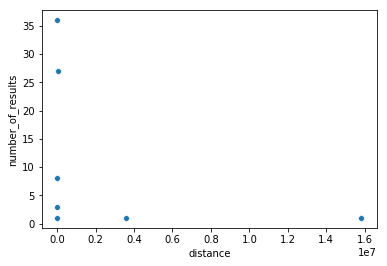

In [142]:
sns.scatterplot(x="distance",
              y="number_of_results",
             # hue="Neighbourhood_y",
              data=dfByStreet)